# STA365: Applied Bayesian Inference HW 6
---
## Question 1

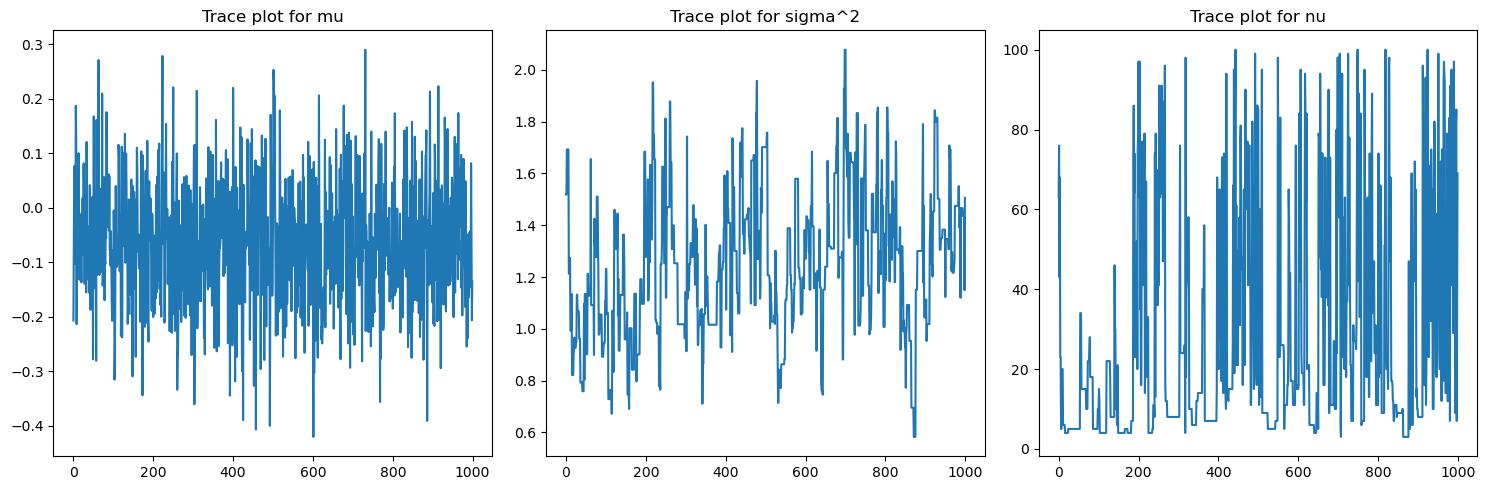

In [53]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def metropolis_within_gibbs(x, mu_0, tau_0, sigma_0, n_iter=1000):
    n = len(x)
    
    # Initialize parameters
    mu = np.mean(x)
    sigma2 = np.var(x)
    nu = np.random.randint(1, 101)
    
    # Storage
    samples = np.zeros((n_iter, 3))
    
    for t in range(n_iter):
        # Sample mu | sigma^2, nu, x (Normal posterior)
        tau_n = tau_0 + n / sigma2
        mu_n = (tau_0 * mu_0 + np.sum(x) / sigma2) / tau_n
        mu = np.random.normal(mu_n, np.sqrt(1 / tau_n))
        
        # Sample sigma^2 | mu, nu, x using Metropolis
        sigma2_prop = np.abs(sigma2 + np.random.normal(0, 0.5))  # Proposal step (random walk)
        
        log_posterior_current = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2))) - (sigma2**2) / (2 * sigma_0**2)
        log_posterior_proposed = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2_prop))) - (sigma2_prop**2) / (2 * sigma_0**2)
        
        log_accept_prob = min(0, log_posterior_proposed - log_posterior_current)
        if np.log(np.random.rand()) < log_accept_prob:
            sigma2 = sigma2_prop
        
        # Sample nu | mu, sigma^2, x using Metropolis
        nu_prop = np.random.randint(1, 101)
        log_posterior_current = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
        log_posterior_proposed = np.sum(stats.t.logpdf(x, df=nu_prop, loc=mu, scale=np.sqrt(sigma2)))
        
        log_accept_prob = min(0, log_posterior_proposed - log_posterior_current)
        if np.log(np.random.rand()) < log_accept_prob:
            nu = nu_prop
        
        # Store samples
        samples[t] = [mu, sigma2, nu]
    
    return samples


mu_0 = 1; tau_0 = 1; sigma_0 = 1
true_mu = 0; true_nu = 5; true_sigma = 1
x = stats.t(df=true_nu, loc=true_mu, scale=true_sigma).rvs(100)

samples = metropolis_within_gibbs(x, mu_0, tau_0, sigma_0, n_iter=1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(samples[:, 0])
axes[0].set_title('Trace plot for mu')
axes[1].plot(samples[:, 1])
axes[1].set_title('Trace plot for sigma^2')
axes[2].plot(samples[:, 2])
axes[2].set_title('Trace plot for nu')

plt.tight_layout()
plt.show()

## Question 2

In [44]:
import pymc as pm
import numpy as np
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt

mu_0 = 1; tau_0 = 1; sigma2_0 = 1
true_mu = 0; true_nu = 5; true_sigma = 1
sample_sizes = [30,100,500]
models = []
traces = {}

for n in sample_sizes:
    x = stats.t(df=true_nu, loc=true_mu, scale=true_sigma).rvs(n)

    with pm.Model() as model:

        # Priors
        nu = pm.DiscreteUniform("nu", lower = 1, upper = 100)
        mu = pm.Normal("mu", mu = mu_0, tau = tau_0)
        sigma2 = pm.HalfNormal("sigma2", sigma = np.sqrt(sigma2_0))

        # Likelihood
        x_obs = pm.StudentT("x_obs", nu = nu, mu = mu, sigma = np.sqrt(sigma2), observed = x)
        
        trace = pm.sample(2000, chains=4,tune=100)
        traces[n] = trace
        models.append(model)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma2]


Sampling 4 chains for 100 tune and 2_000 draw iterations (400 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma2]


Sampling 4 chains for 100 tune and 2_000 draw iterations (400 + 8_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma2]


Sampling 4 chains for 100 tune and 2_000 draw iterations (400 + 8_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.09978,0.20558,-0.48154,0.28213,0.00250,0.00205,6757.43323,4964.76248,1.00104
nu,52.14788,18.88259,14.00000,82.00000,8.01315,5.99367,5.79109,54.30395,1.84964
sigma2,1.24125,0.30881,0.68685,1.78531,0.00433,0.00309,5085.94836,4697.29912,1.00040


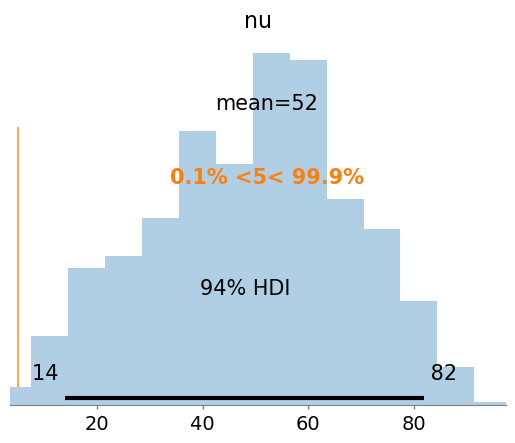

In [45]:
az.plot_posterior(traces[30], var_names=["nu"], ref_val=5)
az.summary(traces[30], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.15002,0.12509,-0.38402,0.08086,0.01169,0.00829,114.82741,3894.67537,1.02459
nu,34.42888,27.81932,3.00000,77.00000,12.38194,9.32838,5.94442,43.64266,1.84359
sigma2,1.31821,0.30462,0.75973,1.85854,0.09020,0.06549,11.67617,146.24892,1.26556


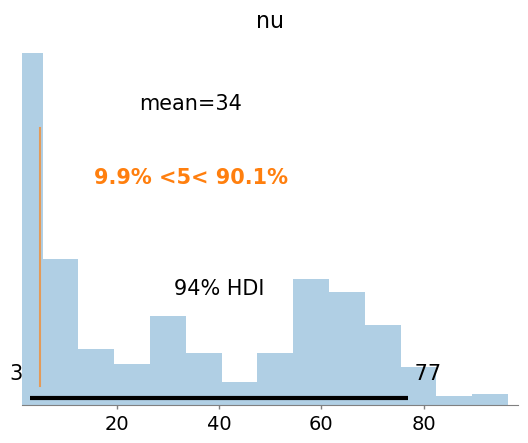

In [46]:
az.plot_posterior(traces[100], var_names=["nu"], ref_val=5)
az.summary(traces[100], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.06848,0.05279,-0.03719,0.16252,0.00057,0.00045,8604.40880,5532.16496,1.00255
nu,6.95250,5.99445,3.00000,15.00000,0.93482,0.66576,114.40869,45.69609,1.01985
sigma2,1.07157,0.14913,0.79812,1.36614,0.01569,0.01193,158.65875,57.70029,1.02222


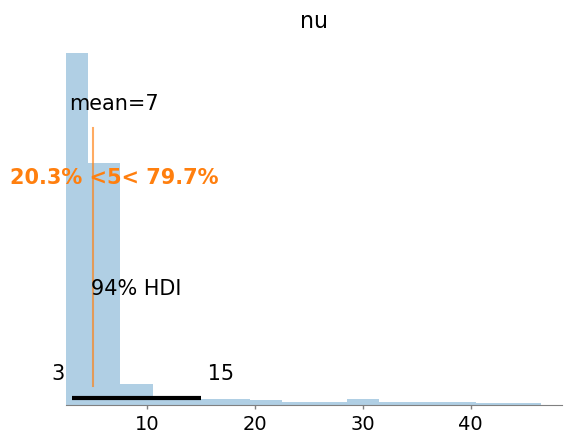

In [47]:
az.plot_posterior(traces[500], var_names=["nu"], ref_val=5)
az.summary(traces[500], round_to=5)

- As sample size increases, the standard deviation for $\nu$ decreases, the credible interval for $\nu$ narrows, the differences between chains $\hat R$ decreases, and $\nu$ gets closer and closer to its true value

## Question 3

\begin{split}
P(y_i) &= \int P(y_i, \tau_i) d\tau_i \\
&= \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i \\
&= \frac{\frac{\nu}{2}^\frac{\nu}{2}}{\Gamma(\frac{\nu}{2})\sqrt{2\pi}} \int \tau_i^{\frac{1}{2}(\nu+1)-1}e^{-\tau_i(\frac{y_i^2+\nu}{2})} d\tau_i \\
&= \frac{\frac{\nu}{2}^\frac{\nu}{2}}{\Gamma(\frac{\nu}{2})\sqrt{2\pi}} \int Gamma(\alpha=\frac{1}{2}(\nu+1),\lambda = \frac{y_i^2+\nu}{2}) \\
&= \frac{\frac{\nu}{2}^\frac{\nu}{2}}{\Gamma(\frac{\nu}{2})\sqrt{2\pi}} \cdot \frac{\Gamma(\frac{\nu+1}{2})}{(\frac{y_i^2+\nu}{2})^\frac{\nu+1}{2}} \\
&= \frac{\frac{\nu}{2}^\frac{\nu}{2}}{\Gamma(\frac{\nu}{2})\sqrt{2\pi}} \cdot \frac{\Gamma(\frac{\nu+1}{2})}{(\frac{\nu}{2})^\frac{\nu+1}{2}(\frac{y_i^2}{\nu}+1)^\frac{\nu+1}{2}} \\
&= \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2})\sqrt{\pi\nu}} \cdot (\frac{y_i^2}{\nu}+1)^{-(\frac{\nu+1}{2})} \\
&\sim t\ dis(\nu)
\end{split}

This result shows that marginalizing over the latent precision, $\tau_i$ introduces heavier tails than a normal distribution. This is directly analogous to the posterior predictive distribution in Bayesian inference—where integrating out the uncertainty in latent parameters (e.g., precision) results in a t-distributed predictive distribution rather than a normal one.